In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from typing import Tuple

def load_image(image_path: str) -> np.ndarray:
    img = cv.imread(image_path)
    return img

def to_grayscale(image: np.ndarray) -> np.ndarray:
    img_gray = cv.cvtColor(np.float32(image), cv.COLOR_BGR2GRAY)
    return img_gray

def apply_gaussian_filter(image: np.ndarray, kernel_size: Tuple[int, int], sigma: float) -> np.ndarray:
    img_smooth = cv.GaussianBlur(image, kernel_size, sigma)
    return img_smooth

def calculate_gradients(image: np.ndarray, kernel_size: int) -> Tuple[np.ndarray, np.ndarray]:
    sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Gx = cv.filter2D(src=image, kernel=sobel_x, ddepth=-1)
    Gy = cv.filter2D(src=image, kernel=sobel_y, ddepth=-1)
    gradient_mag = np.sqrt(Gx**2 + Gy**2)
    gradient_dir = np.arctan2(Gy, Gx) * 180 / np.pi
    return gradient_mag, gradient_dir

def non_maximum_suppression(gradient_mag: np.ndarray, gradient_dir: np.ndarray) -> np.ndarray:
    M, N = gradient_mag.shape
    nms = np.zeros((M, N), dtype=np.int32)
    for i in range(1, M-1):
        for j in range(1, N-1):
            dir = gradient_dir[i, j]
            if dir < 0:
                dir += 180
            dir_round = int((dir + 22.5) / 45) % 4
            if dir_round == 0:  # East-West (horizontal)
                if (gradient_mag[i, j] > gradient_mag[i, j-1]) and (gradient_mag[i, j] > gradient_mag[i, j+1]):
                    nms[i, j] = gradient_mag[i, j]
            elif dir_round == 1:  # North-East/South-West
                if (gradient_mag[i, j] > gradient_mag[i-1, j+1]) and (gradient_mag[i, j] > gradient_mag[i+1, j-1]):
                    nms[i, j] = gradient_mag[i, j]
            elif dir_round == 2:  # North-South (vertical)
                if (gradient_mag[i, j] > gradient_mag[i-1, j]) and (gradient_mag[i, j] > gradient_mag[i+1, j]):
                    nms[i, j] = gradient_mag[i, j]
            elif dir_round == 3:  # North-West/South-East
                if (gradient_mag[i, j] > gradient_mag[i-1, j-1]) and (gradient_mag[i, j] > gradient_mag[i+1, j+1]):
                    nms[i, j] = gradient_mag[i, j]
    return nms

def hysteresis_thresholding(image: np.ndarray, high_threshold_ratio: float, low_threshold_ratio: float) -> np.ndarray:
    high_threshold = np.max(image) * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio
    
    strong_edges = image > high_threshold
    weak_edges = (image > low_threshold) & (image < high_threshold)
    
    # Iterate over all weak edges and check if there is any strong edge in the 3x3 neighborhood
    # If yes, convert weak edge to strong edge
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if weak_edges[i, j]:
                if strong_edges[i-1:i+2, j-1:j+2].any():
                    strong_edges[i, j] = True
                    weak_edges[i, j] = False
    
    return strong_edges


def display_image(image: np.ndarray):
    plt.imshow(image)
    plt.show()

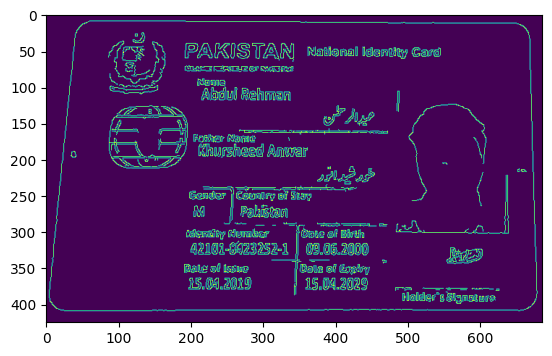

In [3]:
# Opencv Canny
img = cv.imread('img.jpeg', 0)
edges = edges = cv.Canny(img,100,200)
plt.imshow(edges)